In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn.preprocessing as preprocessing
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')
#%matplotlib inline

train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

print(train_data.shape)
print(test_data.shape)


(891, 12)
(418, 11)


In [2]:
full = train_data.append(test_data,ignore_index=True)
full.describe()
full.info()

#Age/Cabin/Embarked/Fare
#Cabin->1/4 miss

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


Embarked->S,Survival rate0.34
Embarked->C,Survival rate0.55
Embarked->Q,Survival rate0.39


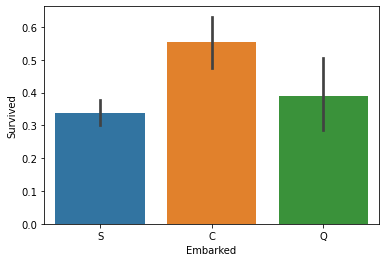

In [3]:
sns.barplot(data=train_data,x='Embarked',y='Survived')
print("Embarked->S,Survival rate%.2f"%full["Survived"][full['Embarked']=='S'].value_counts(normalize=True)[1])
print("Embarked->C,Survival rate%.2f"%full["Survived"][full['Embarked']=='C'].value_counts(normalize=True)[1])
print("Embarked->Q,Survival rate%.2f"%full["Survived"][full['Embarked']=='Q'].value_counts(normalize=True)[1])

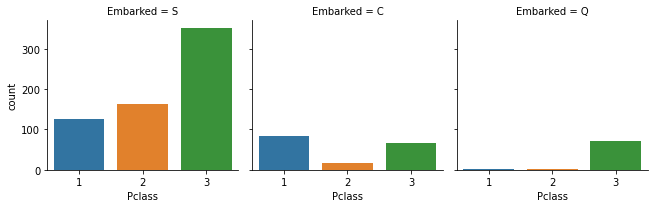

In [4]:
sns.factorplot("Pclass",col="Embarked",data=train_data,kind='count',size=3)

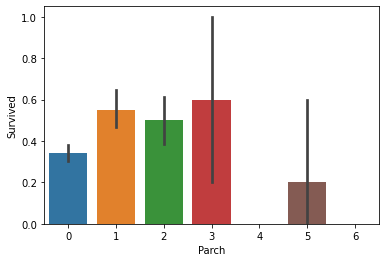

In [5]:
sns.barplot(data=train_data,x="Parch",y="Survived")

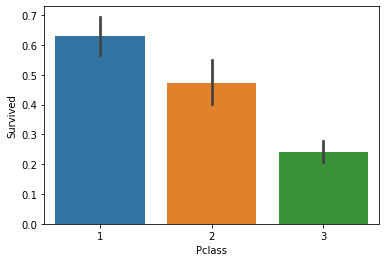

In [6]:
sns.barplot(data=train_data,x="Pclass",y="Survived")
#Pclass->1の場合Survived　rate最も高い

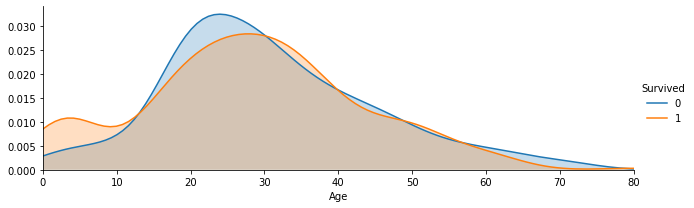

In [7]:
#X軸
ageFacet = sns.FacetGrid(train_data,hue="Survived",aspect=3)

ageFacet.map(sns.kdeplot,"Age",shade=True)
ageFacet.set(xlim=(0,train_data["Age"].max()))
ageFacet.add_legend()

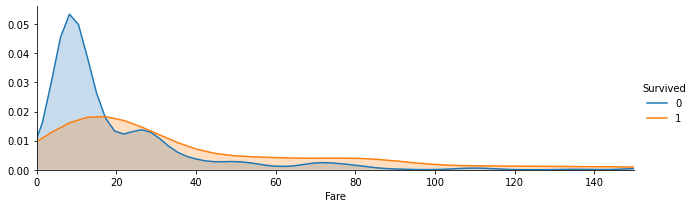

In [8]:
fareFacet=sns.FacetGrid(train_data,hue='Survived',aspect=3)
fareFacet.map(sns.kdeplot,'Fare',shade=True)
fareFacet.set(xlim=(0,150))
fareFacet.add_legend()

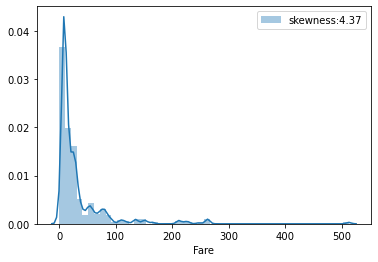

In [9]:
farePlot=sns.distplot(full['Fare'][full['Fare'].notnull()],label='skewness:%.2f'%(full['Fare'].skew()))
farePlot.legend(loc='best')
full['Fare']=full['Fare'].map(lambda x: np.log(x) if x>0 else 0)
#fare的分布呈左偏的形态，其偏度skewness=4.37较大，说明数据偏移平均值较多，
#因此我们需要对数据进行对数化处理，防止数据权重分布不均匀。

In [10]:
#データの前処理
full["Cabin"] = full["Cabin"].fillna("U")
full["Cabin"].head()

0       U
1     C85
2       U
3    C123
4       U
Name: Cabin, dtype: object

In [11]:
full[full["Embarked"].isnull()]

full["Embarked"] = full["Embarked"].fillna("S")
full["Embarked"].value_counts()

S    916
C    270
Q    123
Name: Embarked, dtype: int64

In [12]:
full[full['Fare'].isnull()]
full['Fare']=full['Fare'].fillna(full[(full['Pclass']==3)&(full['Embarked']=='C')&(full['Cabin']=='U')]['Fare'].mean())

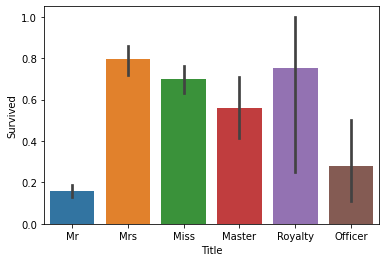

In [13]:
#feature engineering
#构造新特征Title
full['Title']=full['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())
#查看title数据分布
full['Title'].value_counts()

TitleDict={}
TitleDict['Mr']='Mr'
TitleDict['Mlle']='Miss'
TitleDict['Miss']='Miss'
TitleDict['Master']='Master'
TitleDict['Jonkheer']='Master'
TitleDict['Mme']='Mrs'
TitleDict['Ms']='Mrs'
TitleDict['Mrs']='Mrs'
TitleDict['Don']='Royalty'
TitleDict['Sir']='Royalty'
TitleDict['the Countess']='Royalty'
TitleDict['Dona']='Royalty'
TitleDict['Lady']='Royalty'
TitleDict['Capt']='Officer'
TitleDict['Col']='Officer'
TitleDict['Major']='Officer'
TitleDict['Dr']='Officer'
TitleDict['Rev']='Officer'

full['Title']=full['Title'].map(TitleDict)
full['Title'].value_counts()
sns.barplot(data=full,x='Title',y='Survived')

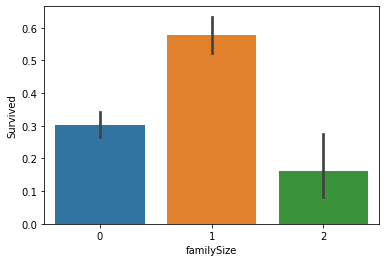

In [14]:
full['familyNum']=full['Parch']+full['SibSp']+1

def familysize(familyNum):
    if familyNum==1:
        return 0
    elif (familyNum>=2)&(familyNum<=4):
        return 1
    else:
        return 2

full['familySize']=full['familyNum'].map(familysize)
full['familySize'].value_counts()

sns.barplot(data=full,x='familySize',y='Survived')

In [15]:
full[full["Age"].isnull()].head()
#筛选数据集
AgePre=full[['Age','Parch','Pclass','SibSp','Title','familyNum']]

AgePre=pd.get_dummies(AgePre)
ParAge=pd.get_dummies(AgePre['Parch'],prefix='Parch')
SibAge=pd.get_dummies(AgePre['SibSp'],prefix='SibSp')
PclAge=pd.get_dummies(AgePre['Pclass'],prefix='Pclass')

#相关性
AgeCorrDf=pd.DataFrame()
AgeCorrDf=AgePre.corr()
AgeCorrDf['Age'].sort_values()

AgePre=pd.concat([AgePre,ParAge,SibAge,PclAge],axis=1)
AgePre.head()

,Age,Parch,Pclass,SibSp,familyNum,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Pclass_1,Pclass_2,Pclass_3
0,22.0,0,3,1,2,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
1,38.0,0,1,1,2,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2,26.0,0,3,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,35.0,0,1,1,2,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4,35.0,0,3,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [16]:
#randomForestRegressor to pred AGE
AgeKnown=AgePre[AgePre['Age'].notnull()]
AgeUnKnown=AgePre[AgePre['Age'].isnull()]

#label
AgeKnown_X=AgeKnown.drop(['Age'],axis=1)
AgeKnown_y=AgeKnown['Age']

AgeUnKnown_X=AgeUnKnown.drop(['Age'],axis=1)

from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(random_state=None,n_estimators=500,n_jobs=-1)
rfr.fit(AgeKnown_X,AgeKnown_y)

rfr.score(AgeKnown_X,AgeKnown_y)

0.5310176440197616

In [17]:
AgeUnKnown_y = rfr.predict(AgeUnKnown_X)
full.loc[full['Age'].isnull(),['Age']]=AgeUnKnown_y
full.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
 13  familyNum    1309 non-null   int64  
 14  familySize   1309 non-null   int64  
dtypes: float64(3), int64(6), object(6)
memory usage: 153.5+ KB


In [18]:
###!!!!!!point!!!!!
#找出具有明显同组效应且违背整体规律的数据，对其数据进行修正
full['Surname']=full['Name'].map(lambda x:x.split(',')[0].strip())
SurNameDict={}
SurNameDict=full['Surname'].value_counts()
full['SurnameNum']=full['Surname'].map(SurNameDict)

MaleDf=full[(full['Sex']=='male')&(full['Age']>12)&(full['familyNum']>=2)]
FemChildDf=full[((full['Sex']=='female')|(full['Age']<=12))&(full['familyNum']>=2)]

In [19]:
MSurNamDf=MaleDf['Survived'].groupby(MaleDf['Surname']).mean()
MSurNamDf.head()
MSurNamDf.value_counts()

MSurNamDict={}
MSurNamDict=MSurNamDf[MSurNamDf.values==1].index
MSurNamDict


Index(['Beane', 'Beckwith', 'Bishop', 'Cardeza', 'Chambers', 'Dick',
       'Duff Gordon', 'Frauenthal', 'Frolicher-Stehli', 'Goldenberg',
       'Greenfield', 'Harder', 'Hoyt', 'Kimball', 'Lindqvist', 'McCoy',
       'Nakid', 'Persson', 'Taylor'],
      dtype='object', name='Surname')

In [20]:
FCSurNamDf=FemChildDf['Survived'].groupby(FemChildDf['Surname']).mean()
FCSurNamDf.head()
FCSurNamDf.value_counts()

FCSurNamDict={}
FCSurNamDict=FCSurNamDf[FCSurNamDf.values==0].index
FCSurNamDict

Index(['Ahlin', 'Arnold-Franchi', 'Barbara', 'Boulos', 'Bourke', 'Caram',
       'Danbom', 'Ford', 'Goodwin', 'Ilmakangas', 'Johnston', 'Jussila',
       'Lahtinen', 'Lefebre', 'Lobb', 'Palsson', 'Panula', 'Rice', 'Robins',
       'Rosblom', 'Sage', 'Skoog', 'Strom', 'Turpin', 'Van Impe',
       'Vander Planke', 'Zabour'],
      dtype='object', name='Surname')

In [21]:
#从数据我们发现一般性别为男性的乘客幸存率较低，而女性及幼童的幸存率较高，
#因此我们将具有同组识别为幸存的男性的数据进行修饰，以提升模型将其预测为幸存的概率。

#for male have same family name -> girl 5 years old 
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(MSurNamDict))&(full['Sex']=='male'),'Age']=5
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(MSurNamDict))&(full['Sex']=='male'),'Sex']='female'

full.loc[(full['Survived'].isnull())&(full['Surname'].isin(FCSurNamDict))&((full['Sex']=='female')|(full['Age']<=12)),'Age']=60
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(FCSurNamDict))&((full['Sex']=='female')|(full['Age']<=12)),'Sex']='male'


In [22]:
fullSel=full.drop(['Cabin','Name','Ticket','PassengerId','Surname','SurnameNum'],axis=1)
corrDf=pd.DataFrame()
corrDf=fullSel.corr()
corrDf['Survived'].sort_values(ascending=True)

Pclass       -0.338481
Age          -0.060026
SibSp        -0.035322
familyNum     0.016639
Parch         0.081629
familySize    0.108631
Fare          0.331805
Survived      1.000000
Name: Survived, dtype: float64

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text major ticklabel objects>)

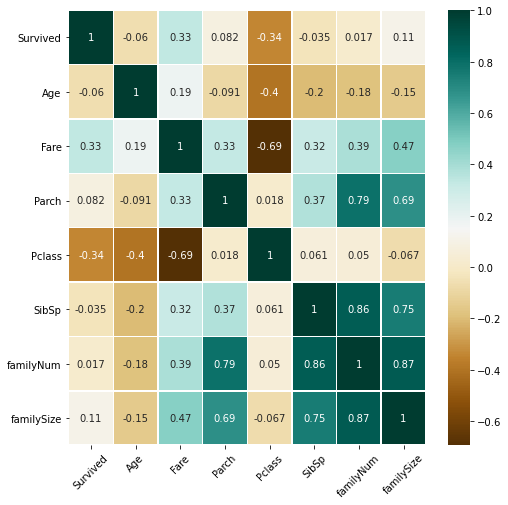

In [23]:
plt.figure(figsize=(8,8))
sns.heatmap(fullSel[['Survived','Age','Embarked','Fare','Parch','Pclass',
                    'Sex','SibSp','Title','familyNum','familySize',]].corr(),cmap='BrBG',annot=True,
           linewidths=.5)
plt.xticks(rotation=45)

In [24]:
fullSel=fullSel.drop(['familyNum','SibSp','Parch'],axis=1)
#one-hot编码
fullSel=pd.get_dummies(fullSel)
PclassDf=pd.get_dummies(full['Pclass'],prefix='Pclass')
familySizeDf=pd.get_dummies(full['familySize'],prefix='familySize')

fullSel=pd.concat([fullSel,PclassDf,familySizeDf],axis=1)

In [25]:
##point2 选择多种模型进行比较从而判断模型更适合用哪个算法

experData=fullSel[fullSel['Survived'].notnull()]
preData=fullSel[fullSel['Survived'].isnull()]

experData_X=experData.drop('Survived',axis=1)
experData_y=experData['Survived']
preData_X=preData.drop('Survived',axis=1)

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold

kfold=StratifiedKFold(n_splits=10)

classifiers=[]
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LinearDiscriminantAnalysis())

cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,experData_X,experData_y,
                                      scoring='accuracy',cv=kfold,n_jobs=-1))
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cvResDf=pd.DataFrame({'cv_mean':cv_means,
                     'cv_std':cv_std,
                     'algorithm':['SVC','DecisionTreeCla','RandomForestCla','ExtraTreesCla',
                                  'GradientBoostingCla','KNN','LR','LinearDiscrimiAna']})

cvResDf

,cv_mean,cv_std,algorithm
0,0.762135,0.052244,SVC
1,0.767790,0.060923,DecisionTreeCla
2,0.812609,0.039032,RandomForestCla
3,0.791236,0.041234,ExtraTreesCla
4,0.836167,0.049173,GradientBoostingCla
5,0.800262,0.039591,KNN
6,0.828315,0.037780,LR
7,0.827166,0.032991,LinearDiscrimiAna


In [26]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }
modelgsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, 
                                     scoring="accuracy", n_jobs= -1, verbose = 1)
modelgsGBC.fit(experData_X,experData_y)


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   49.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'loss': ['deviance'], 'max_depth': [4, 8],
                         'max_features': [0.3, 0.1],
                         'min_samples_leaf': [100, 150],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [27]:
modelLR=LogisticRegression()
LR_param_grid = {'C' : [1,2,3],
                'penalty':['l1','l2']}
modelgsLR = GridSearchCV(modelLR,param_grid = LR_param_grid, cv=kfold, 
                                     scoring="accuracy", n_jobs= -1, verbose = 1)
modelgsLR.fit(experData_X,experData_y)


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 2, 3], 'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

In [28]:

LRpreData_y = modelLR.predict(preData_X)
LRpreData_y = LRpreData_y.astyoe(int)

LRpreResultDf=pd.DataFrame()
LRpreResultDf['PassengerId']=full['PassengerId'][full['Survived'].isnull()]
LRpreResultDf['Survived']=LRpreData_y
LRpreResultDf

LRpreResultDf.to_csv('/kaggle/working/LR_predictions.csv',index = False)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [29]:
%%time
GBCpreData_y=modelgsGBC.predict(preData_X)
GBCpreData_y=GBCpreData_y.astype(int)

GBCpreResultDf=pd.DataFrame()
GBCpreResultDf['PassengerId']=full['PassengerId'][full['Survived'].isnull()]
GBCpreResultDf['Survived']=GBCpreData_y
GBCpreResultDf

GBCpreResultDf.to_csv('/kaggle/working/GBC_predictions.csv',index = False)

CPU times: user 180 ms, sys: 37.8 ms, total: 218 ms
Wall time: 423 ms
